In [ ]:
!apt update && apt install -y python3-opencv
!pip install opencv-python

Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian buster-updates InRelease
Hit:3 http://security.debian.org/debian-security buster/updates InRelease



2 packages can be upgraded. Run 'apt list --upgradable' to see them.



python3-opencv is already the newest version (3.2.0+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def plot_image(image, title):
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(title)
    plt.show()

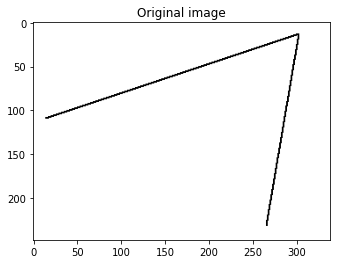

In [ ]:
original_image = cv2.imread('two_lines.png')
plot_image(original_image, 'Original image')

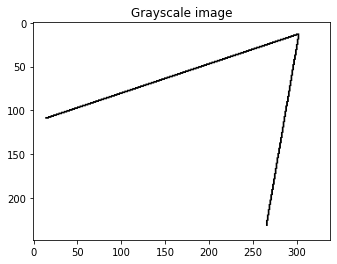

In [ ]:
test_image = cv2.imread('two_lines.png')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
plot_image(test_image, 'Grayscale image')

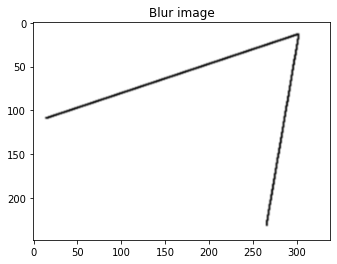

In [ ]:
test_image = cv2.GaussianBlur(test_image, (3,3),0)
plot_image(test_image, 'Blur image')

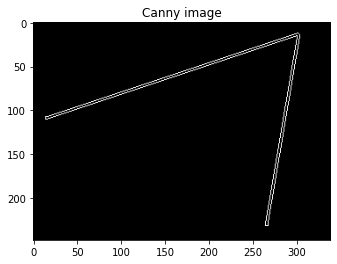

In [ ]:
test_image = cv2.Canny(test_image, 100, 150)
plot_image(test_image, 'Canny image')

In [ ]:
def roi(image):
    top_padding = 0
    bottom_padding = 0 # Front bumper compensation
    height = image.shape[0]
    width = image.shape[1]
    # FYI, below values are highly dependant on the camera calibration i.e what part of the road is actually being captured
    bottom_left = [0, height-bottom_padding]
    bottom_right = [width, height-bottom_padding]
    top_right = [width*1/3, height*1/3 + top_padding]
    top_left = [width*2/3, height*1/3 + top_padding]
    vertices = [np.array([bottom_left, bottom_right, top_left, top_right], dtype=np.int32)]
    mask = np.zeros_like(image)  
    cv2.fillPoly(mask, vertices, 255)
    plot_image(mask, "mask")
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [ ]:
roi_image = roi(test_image)

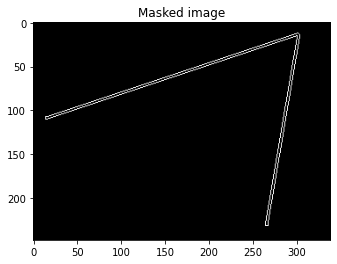

In [ ]:
plot_image(test_image, "Masked image")

In [ ]:
def averaged_lines(image, lines):
    right_lines = []
    left_lines = []
    for x1,y1,x2,y2 in lines[:, 0]:
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope >= 0: 
            right_lines.append([slope, intercept])
        else:
            left_lines.append([slope, intercept])
            
    def merge_lines(image, lines):
        if len(lines) > 0:
            slope, intercept = np.average(lines, axis=0)
            y1 = image.shape[0]
            y2 = int(y1*(1/2))
            x1 = int((y1 - intercept)/slope)
            x2 = int((y2 - intercept)/slope)
            return np.array([x1, y1, x2, y2])
        
    left = merge_lines(image, left_lines)
    right = merge_lines(image, right_lines)
    return left, right

def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is not None:
        lines = averaged_lines(image, lines)
        for line in lines:
            if line is not None:
                x1,y1,x2,y2 = line
                cv2.line(lines_image, (x1, y1), (x2, y2), (0, 0, 255), 20)
        plot_image(lines_image, "lines")
    return lines_image

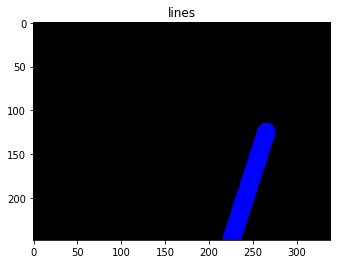

In [ ]:
hough_lines_image = hough_lines(test_image, 0.9, np.pi/180, 100, 100, 50)

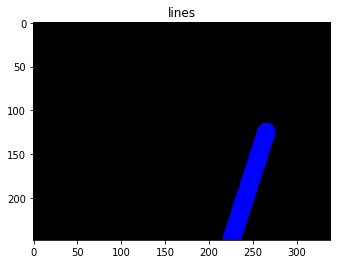

In [ ]:
hough_lines_image_test = hough_lines(test_image, 0.9, np.pi/180, 100, 100, 50)

In [ ]:
def combine_images(image, initial_image, α=0.9, β=1.0, λ=0.0):
    combined_image = cv2.addWeighted(initial_image, α, image, β, λ)
    plot_image(combined_image, "combined")
    return combined_image

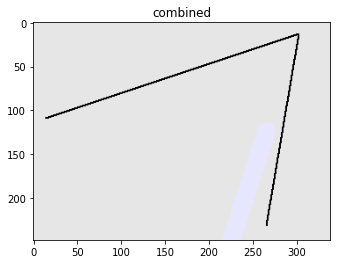

In [ ]:
final_image = combine_images(hough_lines_image, original_image)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=67551570-9d71-4aed-9c87-2895f744897d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>